# Análisis exploratorio de los datos de Dopplerscatt
## Yuritzy Pérez Corona 20/11/2023

#### Dataset: S-MODE Dopplerscatt 
El Experimendo de Dinámica Oceánica a Submesoescala (Sub-Mesoscale Ocean Dynamics Experiment, S-MODE)(Farrar et al., 2020) es una investigación de NASA (Earth Ventures Suborbital Investigation) designada para probar la hipótesis de que los remolinos oceánicos a escala kilométrica ('submesoescala') contribuyen de manera importante al intercambio vertical de variables climáticas y biológicas en el océano superficial. Para probar esta hipótesis, S-MODE emplea una combinación de mediciones de teledetección de la superficie oceánica desde aviones, mediciones desde buques, mediciones desde diversas plataformas oceanográficas autónomas y modelización numérica (Farrar et al., 2020); los experimentos fueron realizados en océano abierto a ~150 km al oeste de San Francisco, California. Los cuatro objetivos científicos que se indican direrctamente en la página oficial del experimento son: 
1) medir la estructura tridimensional de la dinámica submesoescalar responsable del intercambio vertical;
2) cuantificar el papel de la interacción aire-mar y el forzamiento superficial;
3) comprender la relación entre la velocidad oceánica medida por teledetección en la superficie y la que se encuentra justo por debajo de la capa límite superficial; y
4) diagnosticar la dinámica de los procesos de transporte vertical. 

En este proyecto, nos basamos en las mediciones de teledetección de la superficie oceánica desde aviones, que son sus observaciones directas de las velocidades horizontales y sus gradientes mediante el DopplerScatt aerotransportado y plataformas in situ (panel superior de la Figura 1b). El instrumento DopplerScatt es capaz de medir simultáneamente las corrientes oceánicas superficiales y los vientos neutros equivalentes, este está montado en un avión King Air B200 de la NASA, lo que le permite generar un mapa casi sinóptico que cubre un área de 100 por 100 km en un solo vuelo de 4 horas. En este Notebook se muestran algunas de las variables tomadas por el instrumento para un día específico.

![Dopperscatt](sub.jpeg)
Leyenda de la figura: Figura 1. (a) Región del Experimento de Dinámica Oceánica a Subescala (S-MODE) frente a la Bahía de San Francisco, California. (b) Representación esquemática de la plataforma de observación multiescala S-MODE. (c) Vista rápida de las corrientes oceánicas DopplerScatt (líneas de corriente blancas) (procesadas por Ernesto Rodríguez, JPL) y la temperatura de la superficie del mar del Sistema de Observación Multiescala de la Superficie Oceánica (MOSES) (color) (procesada por Jereon Molemaker, UCLA). Obtenida de: https://podaac.jpl.nasa.gov/DataAction-2022-08-29-A-Closer-Look-at-the-Sub-Mesoscale-Ocean-Dynamics-Experiment-S-MODE.

####  Información relevante de los datos
Resolution
Temporal Resolution: 1 second - < 1 minute
 
Coverage
North Bounding Coordinate: 38.2 degrees
South Bounding Coordinate: 36.3 degrees
West Bounding Coordinate: -126.2 degrees
East Bounding Coordinate: -122.1 degrees
Time Span: 2021-Oct-20 to 2021-Nov-05
 
Projection
Projection Type: Universal Transverse Mercator (UTM)
Ellipsoid: WGS 84

####  Se importan librerías

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt, matplotlib.colors as colors, matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import xarray as xr
from scipy import signal, fft, integrate

#### Se lee el archivo

In [2]:
data = xr.open_dataset('dopplerscatt_20211020_140315.tomoL2CF.nc').squeeze() #Carga el archivo en formato xarray
data

<xarray.Dataset>
Dimensions:                           (x: 958, y: 547, line: 8,
                                       triplet_index: 6, triplet_dim: 3)
Coordinates:
  * x                                 (x) float64 2.385e+05 ... 4.298e+05
  * y                                 (y) float64 4.11e+06 ... 4.22e+06
  * line                              (line) int32 2 3 4 5 6 7 8 9
Dimensions without coordinates: triplet_index, triplet_dim
Data variables: (12/44)
    latitude                          (y, x) float32 ...
    longitude                         (y, x) float32 ...
    triplet                           (triplet_index, triplet_dim) int32 ...
    nobs_all_lines                    (y, x) int32 ...
    mean_observation_time             (line, y, x) datetime64[ns] ...
    mean_triplet_observation_time     (triplet_index, y, x) datetime64[ns] ...
    ...                                ...
    v_current_error_triplet           (triplet_index, y, x) float32 ...
    u_current_all_lines               (y, x) float32 ...
    v_current_all_lines               (y, x) float32 ...
    u_current_error_all_lines         (y, x) float32 ...
    v_current_error_all_lines         (y, x) float32 ...
    spatial_ref                       int32 ...
Attributes: (12/82)
    creator_type:                  group
    creator_name:                  E. Rodriguez, A. Wineteer, T. Gal, D. Perk...
    creator_institution:           NASA/JPL
    creator_email:                 ernesto.rodriguez@jpl.nasa.gov
    creator_url:                   https://scholar.google.com/citations?user=...
    creator_role:                  Researcher
    ...                            ...
    meridional_scale:              0.9999359188810929
    parallel_scale:                0.9999359188220885
    svradial_sigma_max:            0.15
    sin_phi_max:                   0.95
    svradial_max:                  3.0
    geospatial_bounds_crs:         EPSG:32610

#### Exploración de las variables
Para acceder a cada variable utilizaremos data.variabledeinteres.
Cada una de las variables tiene su explicación en metadata, para evitar hablar de las 44, aquí se tiene un pequeño resumen de lo observado.
Las observaciones se tienen en regular de 2.5 m por lado, la variable "azimuth_diversity_flag_all_lines", nos dirá los datos que son los correctos por lo que sirve para eliminar los datos erroneos.
Las variables longitud y latitud nos dicen en donde estamos ubicados en el mapa.
Las variables que son de principal interés son el viento (wind) y las corrientes totales (u, la componente al este y v, la componente al norte). 
Cada una de las variables tiene line, donde cada línea de recorrido está por separado; all_lines, donde se consideran todas las mediciones; triplet, que tiene su linea y las líneas adyacentes; y merged, que se usa para estimar las corrientes (en el viento) puede usar valores de line o triplet. El uso de cada una de ellas dependerá de lo que se requiera obtener.
También se tienen los errores para cada una de las variables.

Aquí nos enfocaremos en observar las variables de viento y corrientes en todo el recorrido.

#### Viento
El viento se encuentra en la variable wind_dir_all_lines, esta variable nos da la magnitud del viento. Observaremos los gráficos del módulo de la velocidad del viento y su dirección para el recorrido completo y exploraremos las variables  line y triplet solamente con el módulo de velocidad para entender graficamente como se ven. Si se quiere conocer la dirección se necesitan saber sus componentes en dirección norte y este (vertical y horizontal), para calcularlas utilizamos teorema de Pitágoras sabiendo de los metadatos que la variable considera 0° al norte y 90° al este.

In [3]:
#Calculamos las componentes de la dirección del viento para graficarlo
uwind = np.sin(np.deg2rad(data.wind_dir_all_lines))
vwind = np.cos(np.deg2rad(data.wind_dir_all_lines))

In [4]:
uwind.shape

(547, 958)

Consideraremos un muestreo cada 10 mediciones, para que se observe mejor en la gráfica.

In [5]:
# Definir los vectores de posición
sx, sy = data.latitude.shape 
dz = 10
vsx = np.arange(0, sx, dz) + 1
vsy = np.arange(0, sy, dz) + 1

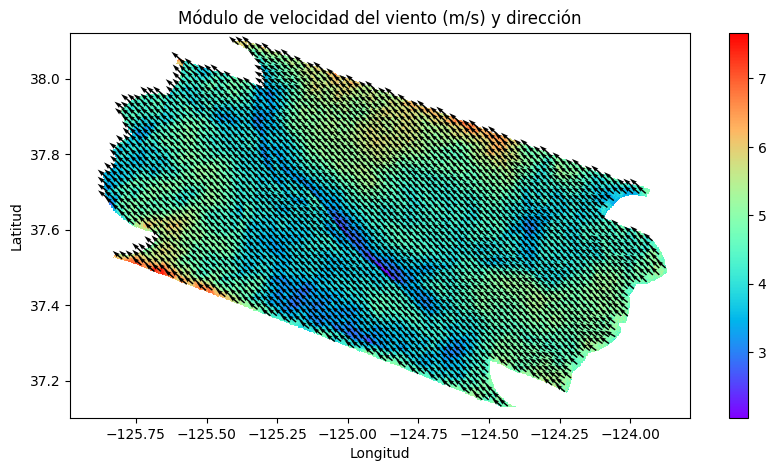

In [6]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10,5))

# Crear un gráfico de colores (pcolor) con la magnitud de la velocidad del viento
pcm= ax.pcolormesh(data.longitude, data.latitude, data.wind_speed_all_lines,cmap='rainbow')

# Agregar una barra de color
cbar = plt.colorbar(pcm, ax=ax)

# Agregar vectores de dirección del viento
ax.quiver(data.longitude[vsx, vsy], data.latitude[vsx, vsy], uwind[vsx, vsy], vwind[vsx, vsy], scale=50, color='k')

# Añadir etiquetas y título
ax.set_title('Módulo de velocidad del viento (m/s) y dirección')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar gráfico
plt.show()

Para las demás variables de viento definimos algunos parámetros a utilizar

In [7]:
# Definir los valores mínimos y máximos para el rango de colores
vmin = 0  # Valor mínimo deseado
vmax = 7  # Valor máximo deseado

# Definir las dimensiones para las cuales se harán los subplots
dimensiones = [0, 1, 2, 3, 4, 5, 6, 7] # Para line y merged
dimensiones2 = [0, 1, 2, 3, 4, 5] # Para triplet

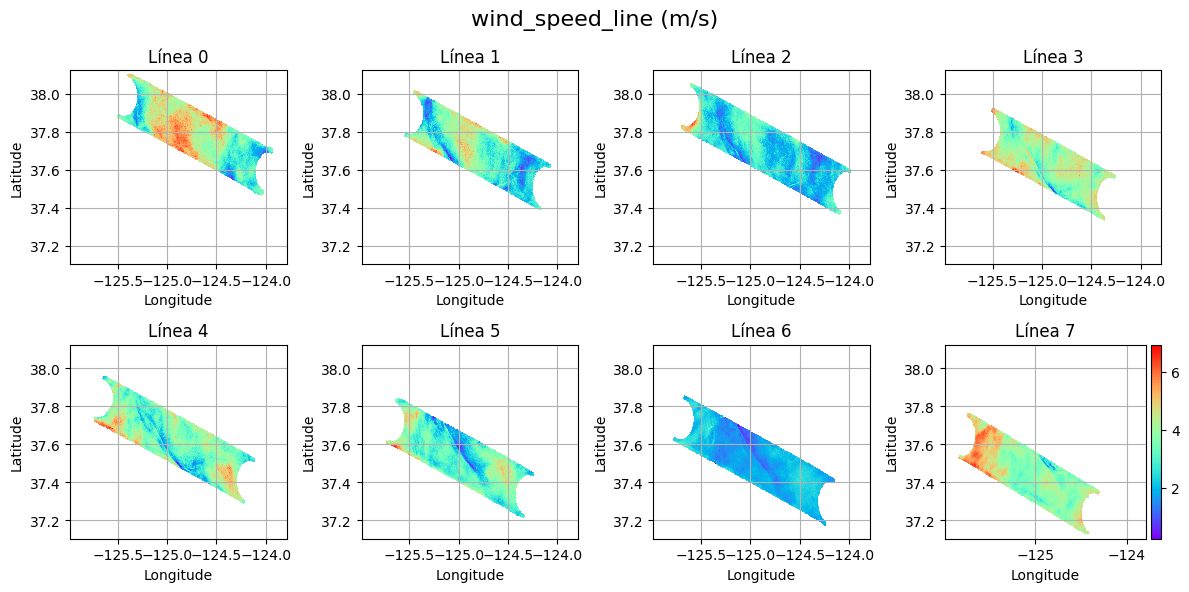

In [8]:
# Configurar la figura y los subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 filas, 4 columnas para 8 subplots

# Iterar sobre las dimensiones y crear subplots
for dim, ax in zip(dimensiones, axes.flatten()):
    # Obtener los datos para la dimensión actual
    windline = data.wind_speed_line[dim, :, :]
    
    # Crear el gráfico de pcolor
    hpc = ax.pcolor(data.longitude, data.latitude, windline, cmap='rainbow')
    
    # Configurar etiquetas y título
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Línea {dim}')
    
    # Añadir una cuadrícula a los subplots
    ax.grid(True)
    
# Añadir un colorbar común para todos los subplots
divider = make_axes_locatable(axes[-1, -1])  # Tomamos el último subplot como referencia
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hpc, cax=cax)#, ticks=[vmin, vmax]) 
#cbar.set_label('Velocidad del viento (m/s)')

# Agregar un título en grande para todas las subfiguras
fig.suptitle('wind_speed_line (m/s)', fontsize=16)
    
# Ajustar los subplots para evitar solapamiento de etiquetas
plt.tight_layout()

# Mostrar la figura
plt.show()

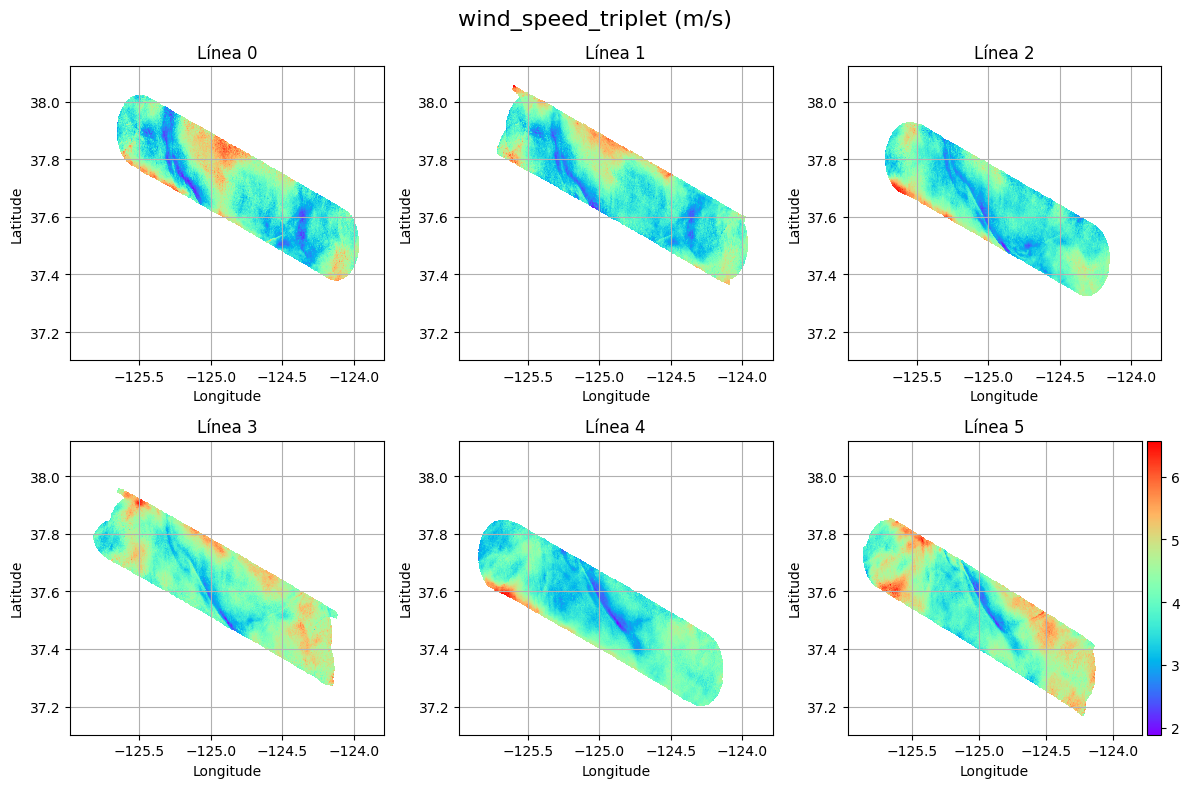

In [9]:
# Configurar la figura y los subplots
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2 filas, 3 columnas para 6 subplots

# Iterar sobre las dimensiones y crear subplots
for dim, ax in zip(dimensiones2, axes.flatten()):
    # Obtener los datos para la dimensión actual
    windtriplet = data.wind_speed_triplet[dim, :, :]
    
    # Crear el gráfico de pcolor
    hpc = ax.pcolor(data.longitude, data.latitude, windtriplet, cmap='rainbow')
    
    # Configurar etiquetas y título
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Línea {dim}')
    
    # Añadir una cuadrícula a los subplots
    ax.grid(True)

# Añadir un colorbar común para todos los subplots
divider = make_axes_locatable(axes[-1, -1])  # Tomamos el último subplot como referencia
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hpc, cax=cax)#, ticks=[vmin, vmax]) 
#cbar.set_label('Velocidad del viento (m/s)')

# Agregar un título en grande para todas las subfiguras
fig.suptitle('wind_speed_triplet (m/s)', fontsize=16)

# Ajustar los subplots para evitar solapamiento de etiquetas
plt.tight_layout()

# Mostrar la figura
plt.show()

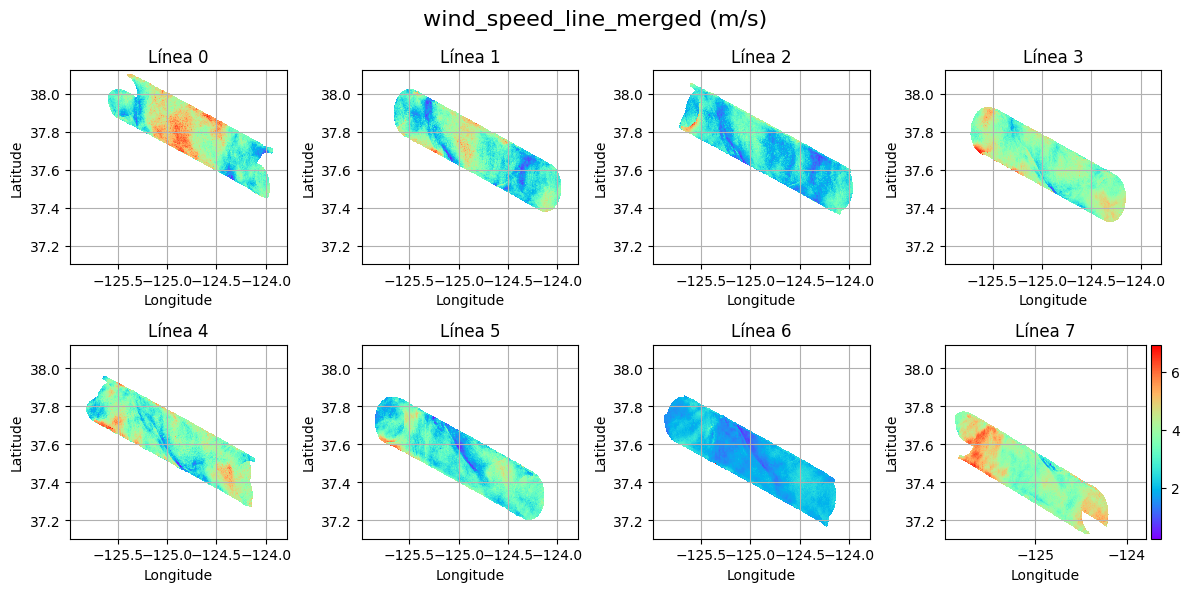

In [10]:
# Configurar la figura y los subplots
fig, axes = plt.subplots(2, 4, figsize=(12, 6))  # 2 filas, 4 columnas para 8 subplots

# Iterar sobre las dimensiones y crear subplots
for dim, ax in zip(dimensiones, axes.flatten()):
    # Obtener los datos para la dimensión actual
    windmerged = data.wind_speed_line_merged[dim, :, :]
    
    # Crear el gráfico de pcolor
    hpc = ax.pcolor(data.longitude, data.latitude, windmerged, cmap='rainbow')
    
    # Configurar etiquetas y título
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(f'Línea {dim}')
    
    # Añadir una cuadrícula a los subplots
    ax.grid(True)
    
# Añadir un colorbar común para todos los subplots
divider = make_axes_locatable(axes[-1, -1])  # Tomamos el último subplot como referencia
cax = divider.append_axes("right", size="5%", pad=0.05)
cbar = plt.colorbar(hpc, cax=cax)#, ticks=[vmin, vmax]) 
#cbar.set_label('Velocidad del viento (m/s)')

# Agregar un título en grande para todas las subfiguras
fig.suptitle('wind_speed_line_merged (m/s)', fontsize=16)
    
# Ajustar los subplots para evitar solapamiento de etiquetas
plt.tight_layout()

# Mostrar la figura
plt.show()

#### Corrientes totales
Para graficar las corrientes oceánicas consideraremos a las variables u_current_all_lines y v_current_all_lines. Calcularemos su magnitud (módulo) por medio de teorema de pitágoras. Antes de ello eliminamos los valores fuera de rango sustituyéndolos por NaN. 

In [11]:
# Aplicar condición para valores mayores a 2 en 'u_current_all_lines'
data['u_current_all_lines'] = xr.where(abs(data['u_current_all_lines']) > 2, np.nan, data['u_current_all_lines'])

# Aplicar condición para valores mayores a 2 en 'v_current_all_lines'
data['v_current_all_lines'] = xr.where(abs(data['v_current_all_lines']) > 2, np.nan, data['v_current_all_lines'])

In [12]:
m_corrientes = np.sqrt(data.u_current_all_lines**2 + data.v_current_all_lines**2)

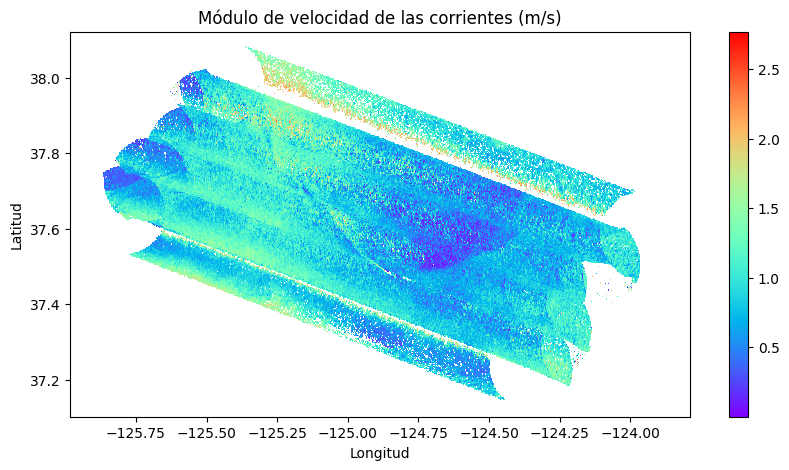

In [13]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(10,5))

# Crear un gráfico de colores (pcolor) con la magnitud de la velocidad del viento
pcm= ax.pcolormesh(data.longitude, data.latitude, m_corrientes, cmap='rainbow')

# Agregar una barra de color
cbar = plt.colorbar(pcm, ax=ax)

# Añadir etiquetas y título
ax.set_title('Módulo de velocidad de las corrientes (m/s)')
ax.set_xlabel('Longitud')
ax.set_ylabel('Latitud')

# Mostrar gráfico
plt.show()

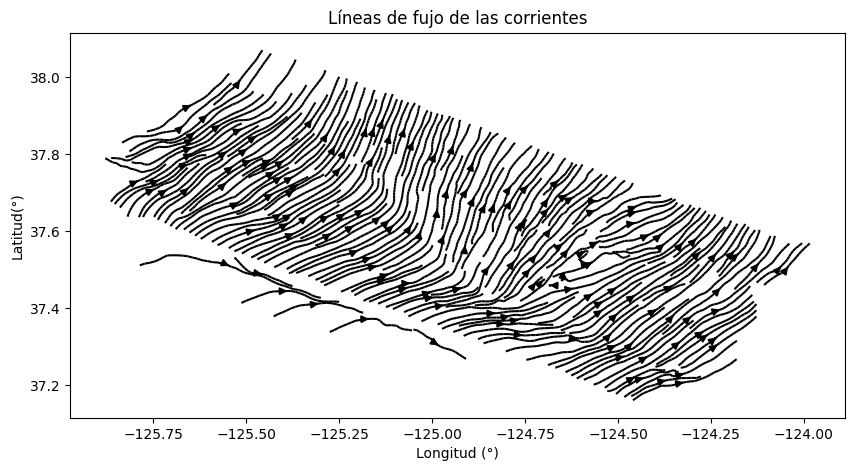

In [14]:
fig, ax = plt.subplots(figsize=(10,5))
x=np.linspace(-126,-123.75,958)
y=np.linspace(37,38.2,547)
stream=ax.streamplot(x, y, data.u_current_all_lines, data.v_current_all_lines, density=5,color='k') 
ax.set_xlabel('Longitud (°)')
ax.set_ylabel('Latitud(°)')
ax.set_title('Líneas de fujo de las corrientes')
plt.show()

#### Vorticidad
La vorticidad (ζ) en el campo de velocidad bidimensional (u, v) se puede calcular utilizando las derivadas espaciales de ∂u y ∂v con respecto a las coordenadas espaciales. La vorticidad se define como la diferencia entre la componente y de la velocidad angular de dos partículas de fluido adyacentes en el campo de velocidad. La fórmula general es:

ζ = ∂v/∂x - ∂u/∂y
 
u es la componente de velocidad en la dirección este-oeste, v es la componente de velocidad en la dirección norte-sur, x es la longitud, y es la latitud.
La vorticidad es fundamental en la dinámica oceánica, y su comprensión ayuda a explicar la formación de giros oceánicos, la generación de ondas oceánicas y otros fenómenos relacionados con la rotación del fluido.

In [15]:
# Calcular las derivadas espaciales
du_dy = data.u_current_all_lines.differentiate('x') / (data.latitude.differentiate('y')*100) #De grados a kilómetros (1°=100km)
dv_dx = data.v_current_all_lines.differentiate('y') / (data.longitude.differentiate('x')*100)
# Calcular la vorticidad
vorticidad = dv_dx - du_dy

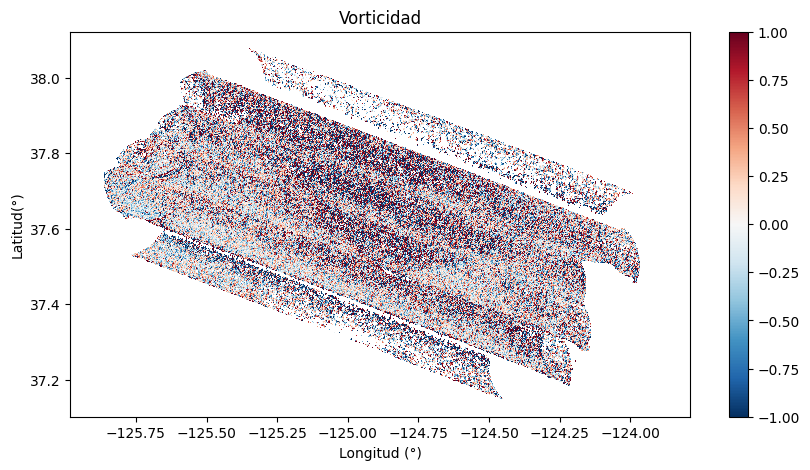

In [16]:
fig, ax = plt.subplots(figsize=(10,5))
# Graficar la vorticidad
vorticidad_plot = ax.pcolormesh(data.longitude, data.latitude, vorticidad, vmax=1,vmin=-1,cmap ='RdBu_r', rasterized=True)

# Agregar barra de color
cbar = plt.colorbar(vorticidad_plot)

# Agregar detalles del mapa
ax.set_title('Vorticidad')
ax.set_xlabel('Longitud (°)')
ax.set_ylabel('Latitud(°)')

# Mostrar el gráfico
plt.show()

#### Divergencia 
La divergencia (δ) se calcula como la suma de las derivadas espaciales de las componentes u y v con respecto a sus respectivas coordenadas. Matemáticamente, se expresa como:

δ = ∂u/∂x + ∂v/∂y

u es la componente de velocidad en la dirección este-oeste,
v es la componente de velocidad en la dirección norte-sur,
x es la longitud,
y es la latitud.

La divergencia es una medida de la variación espacial de las corrientes oceánicas. Un valor positivo de divergencia indica una expansión del flujo, mientras que un valor negativo indica una contracción del flujo. En el contexto oceánico, la divergencia es fundamental para comprender la dinámica de las corrientes y la circulación oceánica. Por ejemplo, las áreas de divergencia suelen estar asociadas con la convergencia en las capas subsuperficiales, lo que puede tener implicaciones para la circulación vertical y la distribución de nutrientes.

In [17]:
# Calcular las derivadas espaciales
du_dx = data.u_current_all_lines.differentiate('x') / (data.longitude.differentiate('x')*100) #De grados a kilómetros (1°=100km)
dv_dy = data.v_current_all_lines.differentiate('y') / (data.latitude.differentiate('y')*100)
# Calcular la vorticidad
divergencia = du_dx + dv_dy

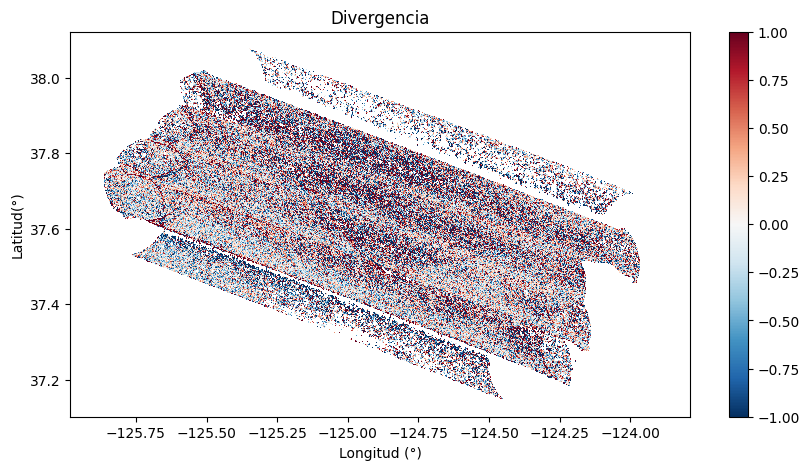

In [18]:
fig, ax = plt.subplots(figsize=(10,5))
# Graficar la vorticidad
vorticidad_plot = ax.pcolormesh(data.longitude, data.latitude, divergencia, vmax=1,vmin=-1,cmap ='RdBu_r', rasterized=True)

# Agregar barra de color
cbar = plt.colorbar(vorticidad_plot)

# Agregar detalles del mapa
ax.set_title('Divergencia')
ax.set_xlabel('Longitud (°)')
ax.set_ylabel('Latitud(°)')

# Mostrar el gráfico
plt.show()

#### Strain
Deformación, parte del tensor de deformación.

σ=[(∂u/∂x - ∂v/∂y)^2+(∂v/∂x + ∂u/∂y)^2]^(1/2)

u es la componente de velocidad en la dirección este-oeste,
v es la componente de velocidad en la dirección norte-sur,
x es la longitud,
y es la latitud.

En el contexto de la dinámica de fluidos, el strain se relaciona con la manera en que las partículas de fluido se deforman en respuesta a un campo de velocidad.

In [19]:
strain = np.sqrt((du_dx-dv_dy)**2+(dv_dx+du_dy)**2)

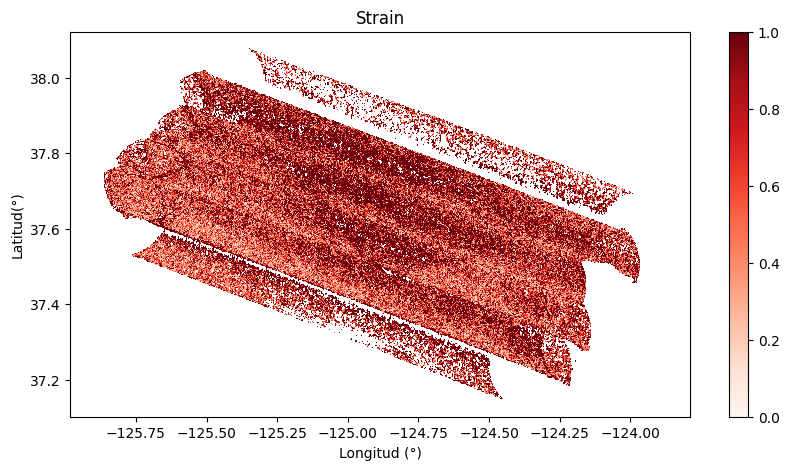

In [20]:
fig, ax = plt.subplots(figsize=(10,5))
# Graficar la vorticidad
vorticidad_plot = ax.pcolormesh(data.longitude, data.latitude, strain, vmax=1,vmin=0,cmap ='Reds', rasterized=True)

# Agregar barra de color
cbar = plt.colorbar(vorticidad_plot)

# Agregar detalles del mapa
ax.set_title('Strain')
ax.set_xlabel('Longitud (°)')
ax.set_ylabel('Latitud(°)')

# Mostrar el gráfico
plt.show()

La combinación de las mediciones DopplerScatt y MOSES en el avión proporciona una visión casi sinóptica muy adecuada para abordar los retos que plantean los movimientos oceánicos a submesoescala. La integración de estos datos de teledetección desde aeronaves con las mediciones in situ del proyecto S-MODE ofrece un conjunto de datos único para validar o refutar los estudios teóricos y numéricos centrados en las submesoescalas durante los últimos 15 años. Contribuye a avanzar en nuestra comprensión de las características dinámicas y a pequeña escala del océano superior, que presentan cambios rápidos. Y lo que es más importante, estos conjuntos de datos y la ciencia que se revelará allanarán el camino a la futura misión por satélite sobre las corrientes oceánicas, como la misión Ocean DYnamics and Surface Exchange with the Atmosphere (ODYSEA).

### Referencias
[1] Data in Action A Closer Look at the Sub-Mesoscale Ocean Dynamics Experiment (S-MODE), obtenido de: https://podaac.jpl.nasa.gov/DataAction-2022-08-29-A-Closer-Look-at-the-Sub-Mesoscale-Ocean-Dynamics-Experiment-S-MODE
[2] 
Farrar, J., et al. (2020) S-MODE: The Sub-Mesoscale Ocean Dynamics Experiment. 2020 IEEE International Geoscience and Remote Sensing Symposium. DOI: 10.1109/IGARSS39084.2020.9323112
[3] 
Rodriguez, E., Wineteer, A., Perkovic-Martin, D., Gál, T., Stiles, B., Niamsuwan, N., Rodriguez Monje, R. (2018) Estimating ocean vector winds and currents using a Ka-Band pencil-beam Doppler scatterometer. Remote Sens. 10, 576. https://doi.org/10.3390/rs100405.
76